In [2]:
# -*- coding: utf-8 -*-
"""
Created on 9/10/2022

@author: raiak
"""

import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta, TH
import matplotlib.pyplot as plt

C:\Users\HP\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\HP\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\HP\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
def optionChain (expirydate):

    urlheader = {
      "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.90 Safari/537.36",
      "authority": "www.nseindia.com",
      "scheme":"https"
    }
    
    url="https://www.nseindia.com/live_market/dynaContent/live_watch/option_chain/optionKeys.jsp?"
    params="segmentLink=17&instrument=OPTIDX&symbol=NIFTY&date="
    #expirydate="3OCT2019"
    
    url_encoded=url + params + expirydate
    
    req = requests.get(url_encoded, headers=urlheader)
    soup = BeautifulSoup(req.content, "lxml")
    table = soup.find('table', id="octable")
    
    rows = table.findAll('tr')
    header_text = []
    headers = rows[1]
    
    remove_indices_for_put = [0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,18,22]
    remove_indices_for_call = [0,4,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,22]
     # Creating an empty Dataframe with column names only
    
    
    # add the header text to array
    for th in headers.findAll('th'):
        header_text.append(th.text)
    
    header_text = [i for j, i in enumerate(header_text) if j not in remove_indices_for_put]
    df_call = pd.DataFrame(columns=header_text)
    df_put = pd.DataFrame(columns=header_text)
    
    #row_text_array = []
    for row in rows[2:-1]:
        row_text = []
        row_text_call = []
        row_text_put = []
        # loop through the elements
        for row_element in row.findAll(['th', 'td']):
            # append the array with the elements inner text
            row_text.append(row_element.text.replace('\n', '').strip())
    
        # append the text array to the row text array
        row_text_put = [i for j, i in enumerate(row_text) if j not in remove_indices_for_put]
        for i in range(len(row_text_put)):
            if (row_text_put[i]=='-'):
                row_text_put[i]=0
            else:
                row_text_put[i]=row_text_put[i].replace(',', '')
                row_text_put[i]=float(row_text_put[i])
        row_text_call = [i for j, i in enumerate(row_text) if j not in remove_indices_for_call]
        row_call_temp=[None] * len(row_text_call)
        for i in range(len(row_text_call)):       
            if (row_text_call[i]=='-'):
                row_call_temp[len(row_text_call)-i-1]=0
            else:
                row_text_call[i]=row_text_call[i].replace(',', '')
                row_text_call[i]=float(row_text_call[i])
                row_call_temp[len(row_text_call)-i-1]=row_text_call[i]
        df_call = df_call.append(pd.Series(dict(zip(df_call.columns, row_call_temp))), ignore_index=True)
        df_put = df_put.append(pd.Series(dict(zip(df_put.columns, row_text_put))), ignore_index=True)    
        
        
    df_call['OI'] = pd.to_numeric(df_call['OI'])
    df_call=df_call.nlargest(3, ['OI'])
    df_call.set_index('Strike Price', inplace=True)
    print("Top 3 Strike price of Call Option based on Open Interest for Expiry Date = "+expirydate)
    df_call=df_call.sort_index(axis = 0) 
    print(df_call)
    
   
    df_call.plot.barh(title='Top 3 Call Option based on OI for Option Expiry = '+expirydate)
    
 
    
    print("================================================================================") 
    df_put['OI'] = pd.to_numeric(df_put['OI'])
    df_put=df_put.nlargest(3, ['OI'])
    df_put.set_index('Strike Price', inplace=True)
    print("Top 3 Strike price of Put Option based on Open Interest for Expiry Date = "+expirydate)
    print(df_put)
    df_put=df_put.sort_index(axis = 0) 
    df_put.plot.barh( title='Top 3 Put Option based on OI for Option Expiry = '+expirydate)
    return(df_call,df_put)

In [4]:
def nextThu_and_lastThu_expiry_date ():

    todayte = datetime.today()
    
    cmon = todayte.month
    if_month_next=(todayte + relativedelta(weekday=TH(1))).month
    next_thursday_expiry=todayte + relativedelta(weekday=TH(1))
   
    if (if_month_next!=cmon):
        month_last_thu_expiry= todayte + relativedelta(weekday=TH(5))
        if (month_last_thu_expiry.month!=if_month_next):
            month_last_thu_expiry= todayte + relativedelta(weekday=TH(4))
    else:
        for i in range(1, 7):
            t = todayte + relativedelta(weekday=TH(i))
            if t.month != cmon:
                # since t is exceeded we need last one  which we can get by subtracting -2 since it is already a Thursday.
                t = t + relativedelta(weekday=TH(-2))
                month_last_thu_expiry=t
                break
    str_month_last_thu_expiry=str(int(month_last_thu_expiry.strftime("%d")))+month_last_thu_expiry.strftime("%b").upper()+month_last_thu_expiry.strftime("%Y")
    str_next_thursday_expiry=str(int(next_thursday_expiry.strftime("%d")))+next_thursday_expiry.strftime("%b").upper()+next_thursday_expiry.strftime("%Y")
    return (str_next_thursday_expiry,str_month_last_thu_expiry)

In [5]:
str_next_thursday_expiry,str_month_last_thu_expiry=nextThu_and_lastThu_expiry_date()
print("================================================================================")
print("Next Expiry Date = " + str_next_thursday_expiry)
print("================================================================================")
print("Month End Expiry Date = " + str_month_last_thu_expiry)
print("================================================================================")

Next Expiry Date = 15SEP2022
Month End Expiry Date = 29SEP2022


In [ ]:
print("Call/Put Option data of next Thursday expiry =  "+str_next_thursday_expiry)
print("================================================================================")
df_call_near_expiry,df_put_near_expiry=optionChain(str_next_thursday_expiry)

Call/Put Option data of next Thursday expiry =  15SEP2022


In [ ]:
print("================================================================================")
print("Call/Put Option data of last Thursday of a month expiry =  "+str_month_last_thu_expiry)
df_put_near_expiry,df_put_last_expiry=optionChain(str_month_last_thu_expiry)
print("================================================================================")

In [1]:
!pip install yfinance
!pip install mpl_finance

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

You should consider upgrading via the 'C:\Users\HP\anaconda3\python.exe -m pip install --upgrade pip' command.



Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


You should consider upgrading via the 'C:\Users\HP\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import yfinance
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)


C:\Users\HP\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\HP\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\HP\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\HP\anaconda3\lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [30]:
name = '^NSEI'
ticker = yfinance.Ticker(name)


In [34]:
df = ticker.history(interval="1d",start="2022-08-12", end="2022-09-10")

# df['Date'] = pd.to_datetime(df.index)
# df['Date'] = df['Date'].apply(mpl_dates.date2num)
# df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
# df

- NSEI: No data found, symbol may be delisted


In [27]:
def isSupport(df,i):
    support = df['Low'][i] < df['Low'][i-1]  and df['Low'][i] < df['Low'][i+1] and df['Low'][i+1] < df['Low'][i+2] and df['Low'][i-1] < df['Low'][i-2]
    return support
def isResistance(df,i):
    resistance = df['High'][i] > df['High'][i-1]  and df['High'][i] > df['High'][i+1] and df['High'][i+1] > df['High'][i+2] and df['High'][i-1] > df['High'][i-2]
    return resistance

In [28]:
levels = []
for i in range(2,df.shape[0]-2):
    if isSupport(df,i):
        levels.append((i,df['Low'][i]))
    elif isResistance(df,i):
        levels.append((i,df['High'][i]))

<ipython-input-29-b290c2a77590>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


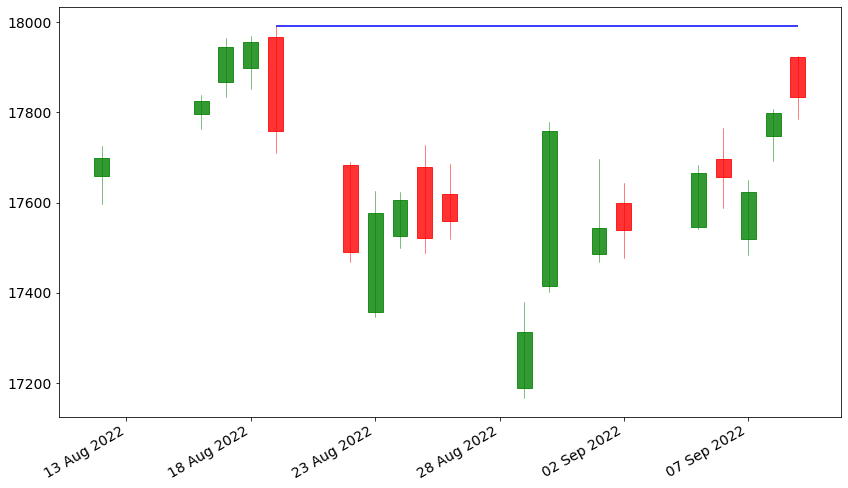

In [29]:
def plot_all():
    fig, ax = plt.subplots()
    candlestick_ohlc(ax,df.values,width=0.6, colorup='green', colordown='red', alpha=0.8)
    date_format = mpl_dates.DateFormatter('%d %b %Y')
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    fig.tight_layout()
    for level in levels:
        plt.hlines(level[1],xmin=df['Date'][level[0]],xmax=max(df['Date']),colors='blue',label='support_and_resistance')
    fig.show()
plot_all()

In [9]:
s =  np.mean(df['High'] - df['Low'])

In [16]:
def isFarFromLevel(l):
    return np.sum([abs(l-x) < s  for x in levels]) == 0

In [17]:
levels = []
for i in range(2,df.shape[0]-2):
  if isSupport(df,i):
    l = df['Low'][i]
    if isFarFromLevel(l):
      levels.append((i,l))
  elif isResistance(df,i):
    l = df['High'][i]
    if isFarFromLevel(l):
      levels.append((i,l))

In [1]:

from nsepy import get_history

In [ ]:
## real time stock predictor 

In [38]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# from keras.models import Sequential
# from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# from nsepy import get_history
from datetime import date

In [ ]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

#Interval required 1 minute
data = yf.download(tickers='UBER', period='1d', interval='1m')

#declare figure
fig = go.Figure()

#Candlestick
fig.add_trace(go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'], name = 'market data'))

# Add titles
fig.update_layout(
    title='Uber live share price evolution',
    yaxis_title='Stock Price (USD per Shares)')

# X-Axes
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label="15m", step="minute", stepmode="backward"),
            dict(count=45, label="45m", step="minute", stepmode="backward"),
            dict(count=1, label="HTD", step="hour", stepmode="todate"),
            dict(count=3, label="3h", step="hour", stepmode="backward"),
            dict(step="all")
        ])
    )
)

#Show
fig.show()

In [1]:
# Libraries
import requests
import json
import math

# Python program to print
# colored text and background
def strRed(skk):         return "\033[91m {}\033[00m".format(skk)
def strGreen(skk):       return "\033[92m {}\033[00m".format(skk)
def strYellow(skk):      return "\033[93m {}\033[00m".format(skk)
def strLightPurple(skk): return "\033[94m {}\033[00m".format(skk)
def strPurple(skk):      return "\033[95m {}\033[00m".format(skk)
def strCyan(skk):        return "\033[96m {}\033[00m".format(skk)
def strLightGray(skk):   return "\033[97m {}\033[00m".format(skk)
def strBlack(skk):       return "\033[98m {}\033[00m".format(skk)
def strBold(skk):        return "\033[1m {}\033[0m".format(skk)

# Method to get nearest strikes
def round_nearest(x,num=50): return int(math.ceil(float(x)/num)*num)
def nearest_strike_bnf(x): return round_nearest(x,100)
def nearest_strike_nf(x): return round_nearest(x,50)

# Urls for fetching Data
url_oc      = "https://www.nseindia.com/option-chain"
url_bnf     = 'https://www.nseindia.com/api/option-chain-indices?symbol=BANKNIFTY'
url_nf      = 'https://www.nseindia.com/api/option-chain-indices?symbol=NIFTY'
url_indices = "https://www.nseindia.com/api/allIndices"

# Headers
headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36',
            'accept-language': 'en,gu;q=0.9,hi;q=0.8',
            'accept-encoding': 'gzip, deflate, br'}

sess = requests.Session()
cookies = dict()

# Local methods
def set_cookie():
    request = sess.get(url_oc, headers=headers, timeout=5)
    cookies = dict(request.cookies)

def get_data(url):
    set_cookie()
    response = sess.get(url, headers=headers, timeout=5, cookies=cookies)
    if(response.status_code==401):
        set_cookie()
        response = sess.get(url_nf, headers=headers, timeout=5, cookies=cookies)
    if(response.status_code==200):
        return response.text
    return ""

def set_header():
    global bnf_ul
    global nf_ul
    global bnf_nearest
    global nf_nearest
    response_text = get_data(url_indices)
    data = json.loads(response_text)
    for index in data["data"]:
        if index["index"]=="NIFTY 50":
            nf_ul = index["last"]
            print("nifty")
        if index["index"]=="NIFTY BANK":
            bnf_ul = index["last"]
            print("banknifty")
    bnf_nearest=nearest_strike_bnf(bnf_ul)
    nf_nearest=nearest_strike_nf(nf_ul)

# Showing Header in structured format with Last Price and Nearest Strike

def print_header(index="",ul=0,nearest=0):
    print(strPurple( index.ljust(12," ") + " => ")+ strLightPurple(" Last Price: ") + strBold(str(ul)) + strLightPurple(" Nearest Strike: ") + strBold(str(nearest)))

def print_hr():
    print(strYellow("|".rjust(70,"-")))

# Fetching CE and PE data based on Nearest Expiry Date
def print_oi(num,step,nearest,url):
    strike = nearest - (step*num)
    start_strike = nearest - (step*num)
    response_text = get_data(url)
    data = json.loads(response_text)
    currExpiryDate = data["records"]["expiryDates"][0]
    for item in data['records']['data']:
        if item["expiryDate"] == currExpiryDate:
            if item["strikePrice"] == strike and item["strikePrice"] < start_strike+(step*num*2):
                #print(strCyan(str(item["strikePrice"])) + strGreen(" CE ") + "[ " + strBold(str(item["CE"]["openInterest"]).rjust(10," ")) + " ]" + strRed(" PE ")+"[ " + strBold(str(item["PE"]["openInterest"]).rjust(10," ")) + " ]")
                print(data["records"]["expiryDates"][0] + " " + str(item["strikePrice"]) + " CE " + "[ " + strBold(str(item["CE"]["openInterest"]).rjust(10," ")) + " ]" + " PE " + "[ " + strBold(str(item["PE"]["openInterest"]).rjust(10," ")) + " ]")
                strike = strike + step

# Finding highest Open Interest of People's in CE based on CE data         
def highest_oi_CE(num,step,nearest,url):
    strike = nearest - (step*num)
    start_strike = nearest - (step*num)
    response_text = get_data(url)
    data = json.loads(response_text)
    currExpiryDate = data["records"]["expiryDates"][0]
    max_oi = 0
    max_oi_strike = 0
    for item in data['records']['data']:
        if item["expiryDate"] == currExpiryDate:
            if item["strikePrice"] == strike and item["strikePrice"] < start_strike+(step*num*2):
                if item["CE"]["openInterest"] > max_oi:
                    max_oi = item["CE"]["openInterest"]
                    max_oi_strike = item["strikePrice"]
                strike = strike + step
    return max_oi_strike

# Finding highest Open Interest of People's in PE based on PE data 
def highest_oi_PE(num,step,nearest,url):
    strike = nearest - (step*num)
    start_strike = nearest - (step*num)
    response_text = get_data(url)
    data = json.loads(response_text)
    currExpiryDate = data["records"]["expiryDates"][0]
    max_oi = 0
    max_oi_strike = 0
    for item in data['records']['data']:
        if item["expiryDate"] == currExpiryDate:
            if item["strikePrice"] == strike and item["strikePrice"] < start_strike+(step*num*2):
                if item["PE"]["openInterest"] > max_oi:
                    max_oi = item["PE"]["openInterest"]
                    max_oi_strike = item["strikePrice"]
                strike = strike + step
    return max_oi_strike

set_header()
print('\033c')
print_hr()
print_header("Nifty",nf_ul,nf_nearest)
print_hr()
print_oi(10,50,nf_nearest,url_nf)
print_hr()
print_header("Bank Nifty",bnf_ul,bnf_nearest)
print_hr()
print_oi(10,100,bnf_nearest,url_bnf)
print_hr()

# Finding Highest OI in Call Option In Nifty
nf_highestoi_CE = highest_oi_CE(10,50,nf_nearest,url_nf)

# Finding Highet OI in Put Option In Nifty
nf_highestoi_PE = highest_oi_PE(10,50,nf_nearest,url_nf)

# Finding Highest OI in Call Option In Bank Nifty
bnf_highestoi_CE = highest_oi_CE(10,100,bnf_nearest,url_bnf)

# Finding Highest OI in Put Option In Bank Nifty
bnf_highestoi_PE = highest_oi_PE(10,100,bnf_nearest,url_bnf)


print(strCyan(str("Major Support in Nifty:")) + str(nf_highestoi_CE))
print(strCyan(str("Major Resistance in Nifty:")) + str(nf_highestoi_PE))
print(strPurple(str("Major Support in Bank Nifty:")) + str(bnf_highestoi_CE))
print(strPurple(str("Major Resistance in Bank Nifty:")) + str(bnf_highestoi_PE))



nifty
banknifty
c
 ---------------------------------------------------------------------|
 Nifty        =>   Last Price:  17833.35  Nearest Strike:  17850
 ---------------------------------------------------------------------|
15-Sep-2022 17350 CE [         197 ] PE [       16858 ]
15-Sep-2022 17400 CE [        1665 ] PE [       48702 ]
15-Sep-2022 17450 CE [         208 ] PE [       15207 ]
15-Sep-2022 17500 CE [        6571 ] PE [       85360 ]
15-Sep-2022 17550 CE [        1208 ] PE [       15986 ]
15-Sep-2022 17600 CE [       10481 ] PE [       73617 ]
15-Sep-2022 17650 CE [        3233 ] PE [       22021 ]
15-Sep-2022 17700 CE [       23108 ] PE [       81901 ]
15-Sep-2022 17750 CE [        8677 ] PE [       19103 ]
15-Sep-2022 17800 CE [       72613 ] PE [       75972 ]
15-Sep-2022 17850 CE [       28882 ] PE [       22920 ]
15-Sep-2022 17900 CE [      124765 ] PE [       69871 ]
15-Sep-2022 17950 CE [       30137 ] PE [        9696 ]
15-Sep-2022 18000 CE [      139322 ] PE [   

In [73]:
import requests
headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; '
            'x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.117 Safari/537.36'}


main_url = "https://www.nseindia.com/"
response = requests.get(main_url, headers=headers)
print(response.status_code)
cookies = response.cookies

url = "https://www.nseindia.com/api/option-chain-indices?symbol=BANKNIFTY"
bank_nifty_oi_data = requests.get(url, headers=headers, cookies=cookies)
print(bank_nifty_oi_data.status_code)
print("BN OI data", bank_nifty_oi_data.text)

url = "https://www.nseindia.com/api/option-chain-indices?symbol=NIFTY"
nifty_oi_data = requests.get(url, headers=headers, cookies=cookies)
print(nifty_oi_data.status_code)
print("Nifty OI data", nifty_oi_data.text)

200
200
BN OI data {"records":{"expiryDates":["15-Sep-2022","22-Sep-2022","29-Sep-2022","06-Oct-2022","13-Oct-2022","27-Oct-2022","24-Nov-2022","29-Dec-2022","30-Mar-2023","29-Jun-2023"],"data":[{"strikePrice":25500,"expiryDate":"29-Sep-2022","PE":{"strikePrice":25500,"expiryDate":"29-Sep-2022","underlying":"BANKNIFTY","identifier":"OPTIDXBANKNIFTY29-09-2022PE25500.00","openInterest":114,"changeinOpenInterest":-40,"pchangeinOpenInterest":-25.974025974025974,"totalTradedVolume":250,"impliedVolatility":72.88,"lastPrice":5.2,"change":2.95,"pChange":131.11111111111111,"totalBuyQuantity":5200,"totalSellQuantity":125,"bidQty":500,"bidprice":3.75,"askQty":125,"askPrice":5.25,"underlyingValue":40415.7},"CE":{"strikePrice":25500,"expiryDate":"29-Sep-2022","underlying":"BANKNIFTY","identifier":"OPTIDXBANKNIFTY29-09-2022CE25500.00","openInterest":0,"changeinOpenInterest":0,"pchangeinOpenInterest":0,"totalTradedVolume":0,"impliedVolatility":0,"lastPrice":0,"change":0,"pChange":0,"totalBuyQuantity"

In [44]:
import json
import pandas as pd 
nifty_dict=json.loads(nifty_oi_data.text)
nifty_dict

{'records': {'expiryDates': ['15-Sep-2022',
   '22-Sep-2022',
   '29-Sep-2022',
   '06-Oct-2022',
   '13-Oct-2022',
   '20-Oct-2022',
   '27-Oct-2022',
   '03-Nov-2022',
   '10-Nov-2022',
   '24-Nov-2022',
   '29-Dec-2022',
   '30-Mar-2023',
   '29-Jun-2023',
   '28-Dec-2023',
   '27-Jun-2024',
   '26-Dec-2024',
   '26-Jun-2025',
   '24-Dec-2025',
   '25-Jun-2026',
   '31-Dec-2026',
   '24-Jun-2027'],
  'data': [{'strikePrice': 7500,
    'expiryDate': '29-Dec-2022',
    'PE': {'strikePrice': 7500,
     'expiryDate': '29-Dec-2022',
     'underlying': 'NIFTY',
     'identifier': 'OPTIDXNIFTY29-12-2022PE7500.00',
     'openInterest': 22,
     'changeinOpenInterest': 0,
     'pchangeinOpenInterest': 0,
     'totalTradedVolume': 0,
     'impliedVolatility': 0,
     'lastPrice': 3,
     'change': 0,
     'pChange': 0,
     'totalBuyQuantity': 1250,
     'totalSellQuantity': 0,
     'bidQty': 50,
     'bidprice': 0.8,
     'askQty': 0,
     'askPrice': 0,
     'underlyingValue': 17833.35}},
 

In [53]:
nifty_dict['filtered']

{'data': [{'strikePrice': 14050,
   'expiryDate': '15-Sep-2022',
   'PE': {'strikePrice': 14050,
    'expiryDate': '15-Sep-2022',
    'underlying': 'NIFTY',
    'identifier': 'OPTIDXNIFTY15-09-2022PE14050.00',
    'openInterest': 1220,
    'changeinOpenInterest': 571,
    'pchangeinOpenInterest': 87.98151001540832,
    'totalTradedVolume': 1836,
    'impliedVolatility': 63.62,
    'lastPrice': 0.6,
    'change': -0.15000000000000002,
    'pChange': -20.000000000000004,
    'totalBuyQuantity': 54150,
    'totalSellQuantity': 83650,
    'bidQty': 2350,
    'bidprice': 0.55,
    'askQty': 850,
    'askPrice': 0.6,
    'underlyingValue': 17833.35},
   'CE': {'strikePrice': 14050,
    'expiryDate': '15-Sep-2022',
    'underlying': 'NIFTY',
    'identifier': 'OPTIDXNIFTY15-09-2022CE14050.00',
    'openInterest': 0,
    'changeinOpenInterest': 0,
    'pchangeinOpenInterest': 0,
    'totalTradedVolume': 0,
    'impliedVolatility': 0,
    'lastPrice': 0,
    'change': 0,
    'pChange': 0,
    '

In [71]:
nifty_dict['records']['timestamp']

'09-Sep-2022 15:30:00'

In [70]:
# ['expiryDates', 'data', 'timestamp', 'underlyingValue', 'strikePrices']
print(len(nifty_dict['records']))
print(len(nifty_dict['records']['timestamp']))

print(len(nifty_dict['records']['expiryDates']))
print(len(nifty_dict['records']['data']))
print(len(nifty_dict['records']['strikePrices']))

5
20
21
1127
166
